<a href="https://colab.research.google.com/github/steo13/aml-gtea61-homework3/blob/main/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Torch 

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install "colorama"

In [1]:
import torch
#use GPU if available 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cpu' # 'cuda' or 'cpu'
print(DEVICE)

cuda:0


# Download Dataset GTEA61

In [ ]:
from google.colab import drive
import os
#drive.mount('/content/drive')
import sys, os
           
if not os.path.isfile('/content/GTEA61.zip'):
  !gdown --id 1Z5RWA8yKIy0PvxMlScV-aAz22ITtivfk # 3-5 min
  !jar xvf  "/content/GTEA61.zip"

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):
  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 # 3-5 min



# Download Code

In [ ]:
!git clone "https://github.com/plana93/Homework_AIML.git" 
#!rm -r "/content/Homework_AIML"



# Import Code


In [7]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torchvision
from colorama import init
from colorama import Fore, Back, Style

from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm
import math
import pandas as pd

import sys
#sys.path.append("/content/Homework_AIML/")
#import Homework_AIML
#from Homework_AIML import *

from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)


#**Learning without Temporal information** (avgpool)

#MAIN PARAMs

In [8]:
#homework_step = 0 #--> Learning without Temporal information (avgpool)
#homework_step = 1 #--> Learning with Temporal information (LSTM)
homework_step = 2 #--> Learning with Spatio-Temporal information (ConvLSTM)

DATA_DIR = '/content/GTEA61/' #path dataset
model_folder = '/content/saved_models/' + "/" + "homework_step"+ str(homework_step) + "/" #path to save model 
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

# All this param can be change!

NUM_CLASSES = 61     
BATCH_SIZE = 64 
LR = 0.001           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 4e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 50     # Total number of training epochs (iterations over dataset)
STEP_SIZE = [25, 75, 150] # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
MEM_SIZE = 512       # Dim of internal state of LSTM or ConvLSTM
SEQ_LEN = 3          # Num Frames

# this dictionary is needed for the logger class
parameters = {'DEVICE':DEVICE, 'NUM_CLASSES':NUM_CLASSES, 'BATCH_SIZE':BATCH_SIZE,
             'LR':LR, 'MOMENTUM':MOMENTUM, 'WEIGHT_DECAY':WEIGHT_DECAY, 'NUM_EPOCHS':NUM_EPOCHS,
             'STEP_SIZE':STEP_SIZE, 'GAMMA':GAMMA, 'MEM_SIZE':MEM_SIZE, 'SEQ_LEN':SEQ_LEN}

#Dataloaders & Preprocessing

In [9]:
# Normalize
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                             ToTensor(), normalize])
spatial_transform_val = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])


In [10]:
# Prepare Pytorch train/test Datasets
train_dataset = GTEA61(DATA_DIR, split='train', transform=spatial_transform, seq_len=SEQ_LEN)
test_dataset = GTEA61(DATA_DIR, split='test', transform=spatial_transform_val, seq_len=SEQ_LEN)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


['S2', 'S1', 'S4', 'S3']
['S2', 'S1', 'S4', 'S3']
Train Dataset: 341
Test Dataset: 116


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #      The code dates back to 2008 and there is no comment on the original


#Model

In [11]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

# LSTM
class MyLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()

        self.conv_i_xx = nn.Linear(input_size, hidden_size)
        self.conv_i_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        self.conv_f_xx = nn.Linear(input_size, hidden_size)
        self.conv_f_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        self.conv_c_xx = nn.Linear(input_size, hidden_size)
        self.conv_c_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        self.conv_o_xx = nn.Linear(input_size, hidden_size)
        self.conv_o_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1)).cuda()))
            
        ht_1, ct_1 = state
        it = F.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(ht_1))
        ft = F.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(ht_1))
        ct_tilde = F.tanh(self.conv_c_xx(x) + self.conv_c_hh(ht_1))
        ct = (ct_tilde * it) + (ct_1 * ft)
        ot = F.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(ht_1))
        ht = ot * F.tanh(ct)
        return ht, ct

#ConvLSTM
class MyConvLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, kernel_size=3, stride=1, padding=1):
        super(MyConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv_i_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_i_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_f_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_f_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_c_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_o_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_o_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()))
        
        ht_1, ct_1 = state
        it = F.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(ht_1))
        ft = F.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(ht_1))
        ct_tilde = F.tanh(self.conv_c_xx(x) + self.conv_c_hh(ht_1))
        ct = (ct_tilde * it) + (ct_1 * ft)
        ot = F.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(ht_1))
        ht = ot * F.tanh(ct)
        return ht, ct

#Network 
class ourModel(nn.Module):
    def __init__(self, num_classes=61, mem_size=512, homework_step = 0 , DEVICE=""):
        super(ourModel, self).__init__()
        self.DEVICE = DEVICE
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.homework_step = homework_step
        if self.homework_step == 1:
          self.lstm_cell = MyLSTMCell(512, mem_size)
        elif self.homework_step == 2:
          self.lstm_cell = MyConvLSTMCell(512, mem_size)

        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)

    def forward(self, inputVariable):
        #Learning without Temporal information (mean)
        if self.homework_step == 0:
            video_level_features = torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE)
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(spatial_frame_feat.size(0), -1)
                video_level_features = video_level_features + frame_feat

            video_level_features = video_level_features / inputVariable.size(0)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        #Learning with Temporal information (LSTM)
        elif self.homework_step == 1:
            state = ( torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE) ) 
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(state[1].size(0), -1)
                state = self.lstm_cell(frame_feat, state)

            video_level_features = state[1]
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        #Learning with Temporal information (ConvLSTM)
        elif self.homework_step == 2:
            state = (torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE))
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                state = self.lstm_cell(spatial_frame_feat, state)
            video_level_features = self.avgpool(state[1]).view(state[1].size(0), -1)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

#Build Model - Loss - Opt

In [12]:
#CUDA_LAUNCH_BLOCKING=1
validate = True

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE) #model

#Train only the lstm cell and classifier
model.train(False)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)

model = model.to(DEVICE)

model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)

#Loss
loss_fn = nn.CrossEntropyLoss()
#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

#Training


In [13]:
train_iter = 0
val_iter = 0
min_accuracy = 0

trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
val_samples = len(test_dataset) 
iterPerEpoch = len(train_loader)
val_steps = len(val_loader)
cudnn.benchmark
model_checkpoint = "model" #name

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    numCorrTrain = 0
    
    #blocks to train
    if homework_step > 0:
        model.lstm_cell.train(True)
    model.classifier.train(True)
    
    
    for i, (inputs, targets) in enumerate(train_loader):
        train_iter += 1
        optimizer_fn.zero_grad()
        
        # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        # feeds in model
        output_label, _ = model(inputVariable)
        
        # compute loss 
        loss = loss_fn(output_label, labelVariable)

        # backward loss and optimizer step 
        loss.backward()
        optimizer_fn.step()
        
        #compute the training accuracy 
        _, predicted = torch.max(output_label.data, 1)
        numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
        step_loss = loss.data.item()
        epoch_loss += step_loss
    
    avg_loss = epoch_loss/iterPerEpoch
    trainAccuracy = (numCorrTrain / trainSamples) * 100
    train_accuracies.append(trainAccuracy)
    train_losses.append(avg_loss)

    #train_logger.add_epoch_data(epoch+1, trainAccuracy, avg_loss)
    print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))
    if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)
                
                output_label, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()
                #val_logger.add_step_data(val_iter, numCorr, val_loss_step)
                
            val_accuracy = (numCorr / val_samples) * 100
            val_accuracies.append(val_accuracy)
            avg_val_loss = val_loss_epoch / val_steps
            val_losses.append(avg_val_loss)

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy
    
    optim_scheduler.step()

print(Fore.CYAN + "Best Acc --> ", min_accuracy)
print(Fore.CYAN + "Last Acc --> ", val_accuracy)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #      The code dates back to 2008 and there is no comment on the original
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train: Epoch = 1 | Loss = 4.322 | Accuracy = 10.938
Val: Epoch = 1 | Loss 2.926 | Accuracy = 16.379
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 3.656 | Accuracy = 13.125
Val: Epoch = 2 | Loss 2.731 | Accuracy = 31.897
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.209 | Accuracy = 20.312
Val: Epoch = 3 | Loss 2.541 | Accuracy = 30.172
Train: Epoch = 4 | Loss = 2.925 | Accuracy = 22.812
Val: Epoch = 4 | Loss 2.518 | Accuracy = 32.759
[||| NEW BEST on val||||]
Train: Epoch = 5 | Loss = 2.793 | Accuracy = 23.438
Val: Epoch = 5 | Loss 2.356 | Accuracy = 33.621
[||| NEW BEST on val||||]
Train: Epoch = 6 | Loss = 2.703 | Accuracy = 29.375
Val: Epoch = 6 | Loss 2.392 | Accuracy = 33.621
Train: Epoch = 7 | Loss = 2.668 | Accuracy = 27.500
Val: Epoch = 7 | Loss 2.330 | Accuracy = 35.345
[||| NEW BEST on val||||]
Train: Epoch = 8 | Loss = 2.468 | Accuracy = 34.375
Val: Epoch = 8 | Loss 2.310 | Accuracy = 34.483
Train: Epoch = 9 | Loss = 2.447 | Accuracy = 31.250
Val: Epoch = 9 | L

Best accuracies on the validation set:  50.0


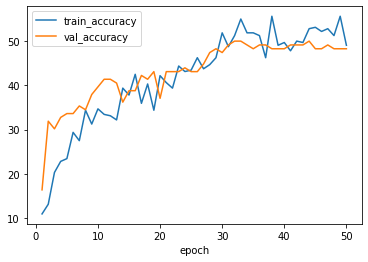

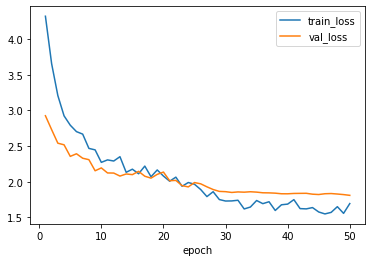

In [14]:
print("Best accuracies on the validation set: ", min_accuracy)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])

#Test

In [15]:
model.train(False)
val_loss_epoch = 0
numCorr = 0
val_iter = 0
val_samples = len(test_dataset) 
val_steps = len(val_loader)

with torch.no_grad():
    for j, (inputs, targets) in enumerate(val_loader):
        val_iter += 1
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)
        
        output_label, _ = model(inputVariable)
        val_loss = loss_fn(output_label, labelVariable)
        val_loss_step = val_loss.data.item()
        val_loss_epoch += val_loss_step
        _, predicted = torch.max(output_label.data, 1)
        numCorr += torch.sum(predicted == labelVariable.data).data.item()
        
    val_accuracy = (numCorr / val_samples) * 100
    avg_val_loss = val_loss_epoch / val_steps

print('Loss {:.3f} | Accuracy = {:.3f}'.format(avg_val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #      The code dates back to 2008 and there is no comment on the original
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss 1.809 | Accuracy = 48.276
